In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

In [89]:
year_2024 = pd.read_csv('../year_2024_2025/Kathmandu_2024_2025.csv')
year_2023 = pd.read_csv('../year_2023/Kathmandu_2023.csv')
year_2022 = pd.read_csv('../year_2022/Kathmandu_2022.csv')
year_2021 =pd.read_csv('../year_2021/Kathmandu_2021.csv')


In [90]:
# Convert the 'Date' column to datetime format
year_2024['Date'] = pd.to_datetime(year_2024['Date'], format='%Y-%m-%d')
year_2023['Date'] = pd.to_datetime(year_2023['Date'], format='%Y-%m-%d')
year_2022['Date'] = pd.to_datetime(year_2022['Date'], format='%Y-%m-%d')
year_2021['Date'] = pd.to_datetime(year_2021['Date'], format='%Y-%m-%d')


In [91]:
# checking for missing values

year_2024.isnull().sum() / len(year_2024) * 100

Date            0.000000
dew             0.000000
humidity        0.000000
pm1            45.665962
pm10            1.902748
pm25            0.000000
pressure        0.000000
temperature     0.000000
wind-speed      0.000000
dtype: float64

In [92]:
year_2023.isnull().sum() / len(year_2023) * 100

Date            0.000000
dew            47.708895
humidity       22.641509
pm1            31.536388
pm10           30.997305
pm25           22.641509
pressure       22.641509
temperature    22.641509
wind-speed     22.641509
dtype: float64

In [93]:
year_2022.isnull().sum() / len(year_2022) * 100

Date            0.000000
dew             0.000000
humidity        0.000000
pm1            38.571429
pm10           34.642857
pm25            0.000000
pressure        0.000000
temperature     0.000000
wind-speed      0.000000
dtype: float64

In [94]:
year_2021.isnull().sum() / len(year_2021) * 100

Date            0.000000
dew             0.808625
humidity        0.808625
pm1            18.598383
pm10           18.598383
pm25            0.000000
pressure        0.808625
temperature     0.808625
wind-speed      0.808625
dtype: float64

In [95]:
year_2021.columns

Index(['Date', 'dew', 'humidity', 'pm1', 'pm10', 'pm25', 'pressure',
       'temperature', 'wind-speed'],
      dtype='object')

### Computing the AQI Value using pm10 and pm2.5

In [96]:
# Standard AQI breakpoints for PM2.5 (µg/m³)
pm25_breakpoints = [
    (0, 12.0),      # Good (0-50)
    (12.1, 35.4),   # Moderate (51-100)
    (35.5, 55.4),   # Unhealthy for Sensitive Groups (101-150)
    (55.5, 150.4),  # Unhealthy (151-200)
    (150.5, 250.4), # Very Unhealthy (201-300)
    (250.5, 500.4)  # Hazardous (301-500)
]

# Standard AQI breakpoints for PM10 (µg/m³)
pm10_breakpoints = [
    (0, 54),        # Good (0-50)
    (55, 154),      # Moderate (51-100)
    (155, 254),     # Unhealthy for Sensitive Groups (101-150)
    (255, 354),     # Unhealthy (151-200)
    (355, 424),     # Very Unhealthy (201-300)
    (425, 604)      # Hazardous (301-500)
]
# Corresponding AQI ranges
# (0, 50): Good
# (51, 100): Moderate
# (101, 150): Unhealthy for Sensitive Groups
# (151, 200): Unhealthy
# (201, 300): Very Unhealthy
# (301, 500): Hazardous
aqi_ranges = [
    (0, 50),
    (51, 100),
    (101, 150),
    (151, 200),
    (201, 300),
    (301, 500)
]                     

In [97]:
def calculate_aqi(pm_value, breakpoints):
    """
    Calculate AQI based on PM value and breakpoints.
    """
    for i, (low_pm, high_pm) in enumerate(breakpoints):
        if low_pm <= pm_value <= high_pm:
            low_aqi, high_aqi = aqi_ranges[i]
            return ((high_aqi - low_aqi) / (high_pm - low_pm)) * (pm_value - low_pm) + low_aqi
    return None  # if value exceeds highest breakpoint

In [98]:
def compute_aqi(data):
    """
    Compute AQI for PM2.5 and PM10, then combine them by taking the maximum for each day.
    Returns a dictionary with:
    - 'date': list of all dates in the original data
    - 'aqi_value': list of corresponding AQI values (max of PM2.5 and PM10 AQI)
    """
    dates = []
    aqi_values = []
    
    for i in range(len(data['Date'])):
        date = data['Date'].iloc[i]
        pm25_value = data['pm25'].iloc[i] if 'pm25' in data else None
        pm10_value = data['pm10'].iloc[i] if 'pm10' in data else None
        
        aqi_pm25 = None
        aqi_pm10 = None
        
        # Calculate AQI for PM2.5 if available
        if pm25_value is not None and not np.isnan(pm25_value):
            aqi_pm25 = calculate_aqi(pm25_value, pm25_breakpoints)
        
        # Calculate AQI for PM10 if available
        if pm10_value is not None and not np.isnan(pm10_value):
            aqi_pm10 = calculate_aqi(pm10_value, pm10_breakpoints)
        
        # Determine final AQI (max of both if available, or whichever is available)
        final_aqi = np.nan  # Default to NaN if both are missing
        if aqi_pm25 is not None and aqi_pm10 is not None:
            final_aqi = max(aqi_pm25, aqi_pm10)
        elif aqi_pm25 is not None:
            final_aqi = aqi_pm25
        elif aqi_pm10 is not None:
            final_aqi = aqi_pm10
        
        dates.append(date)
        aqi_values.append(final_aqi)
    
    return {
        'date': dates,
        'aqi_value': aqi_values
    }

In [99]:
def process_aqi_data(data):
    """
    Compute AQI for the given dataset and convert the 'date' column to datetime format.
    Returns a DataFrame with AQI values and formatted dates.
    """
    aqi_data = pd.DataFrame(compute_aqi(data))
    aqi_data['date'] = pd.to_datetime(aqi_data['date'], format='%Y-%m-%d')
    return aqi_data




In [100]:
# Process AQI data for all years
aqi_2024 = process_aqi_data(year_2024)
aqi_2023 = process_aqi_data(year_2023)
aqi_2022 = process_aqi_data(year_2022)
aqi_2021 = process_aqi_data(year_2021)

In [101]:
print(
    "Missing values percentage in AQI 2023:\n", aqi_2023.isnull().sum() / len(aqi_2023) * 100, "\n",
    "Missing values percentage in AQI 2022:\n", aqi_2022.isnull().sum() / len(aqi_2022) * 100, "\n",
    "Missing values percentage in AQI 2021:\n", aqi_2021.isnull().sum() / len(aqi_2021) * 100
)

Missing values percentage in AQI 2023:
 date          0.000000
aqi_value    22.641509
dtype: float64 
 Missing values percentage in AQI 2022:
 date         0.0
aqi_value    0.0
dtype: float64 
 Missing values percentage in AQI 2021:
 date         0.0
aqi_value    0.0
dtype: float64


In [102]:
def merge_aqi_data(year_data, aqi_data):
    """
    Merge AQI data with the yearly data on the 'Date' column.
    Drops the redundant 'date' column after merging.
    """
    merged_data = pd.merge(year_data, aqi_data, left_on='Date', right_on='date', how='left')
    merged_data.drop(columns=['date'], inplace=True)
    return merged_data



In [103]:
# Apply the function to each year
year_2024 = merge_aqi_data(year_2024, aqi_2024)
year_2023 = merge_aqi_data(year_2023, aqi_2023)
year_2022 = merge_aqi_data(year_2022, aqi_2022)
year_2021 = merge_aqi_data(year_2021, aqi_2021)


In [105]:
year_2023.isnull().sum() / len(year_2021) * 100

Date            0.000000
dew            47.708895
humidity       22.641509
pm1            31.536388
pm10           30.997305
pm25           22.641509
pressure       22.641509
temperature    22.641509
wind-speed     22.641509
aqi_value      22.641509
dtype: float64

In [106]:
def add_aqi_category(data):
    """
    Add a new column to the dataset indicating the air quality level based on AQI ranges.
    """
    def get_aqi_category(aqi_value):
        if aqi_value is None or np.isnan(aqi_value):
            return "Unknown"
        for i, (low, high) in enumerate(aqi_ranges):
            if low <= aqi_value <= high:
                return ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"][i]
        return "Unknown"

    data['AQI_Category'] = data['aqi_value'].apply(get_aqi_category)
    return data

In [107]:
year_2023 = add_aqi_category(year_2023)
year_2022 = add_aqi_category(year_2022)
year_2021 = add_aqi_category(year_2021)
year_2024 = add_aqi_category(year_2024)


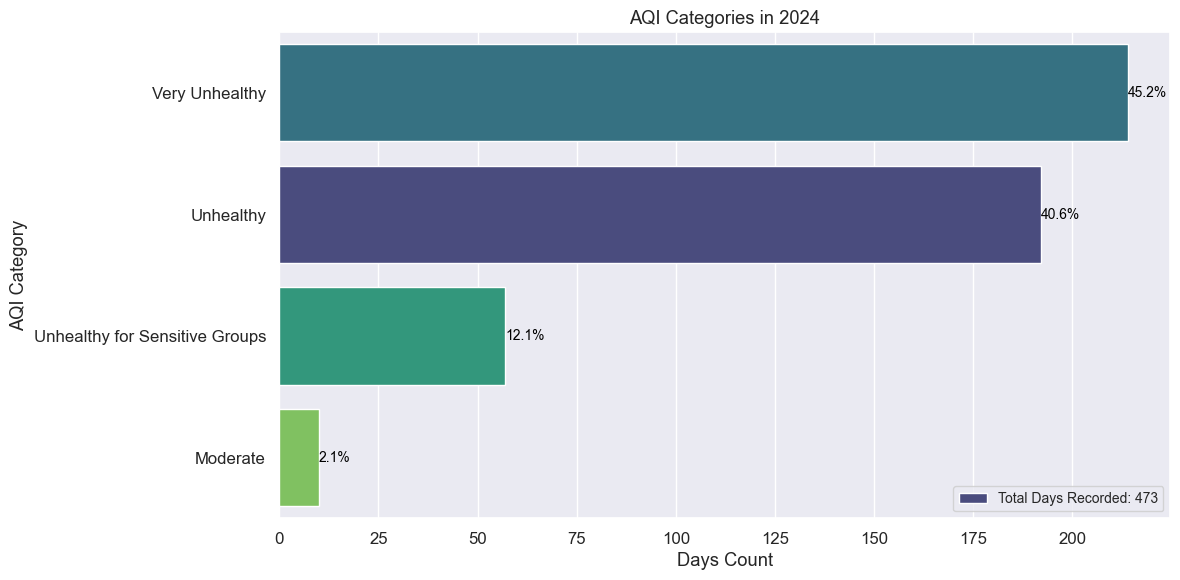

In [133]:
year_2024.AQI_Category.value_counts()

# creating a bar plot for the AQI categories in 2024
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=year_2024, y='AQI_Category', palette='viridis', 
                   order=year_2024['AQI_Category'].value_counts().index, hue='AQI_Category')
plt.title('AQI Categories in 2024')
plt.ylabel('AQI Category')
plt.xlabel('Days Count')

# Adding total number of days recorded as legend
total_days = len(year_2024)
legend_label = f"Total Days Recorded: {total_days}"
plt.legend([legend_label], loc='best', frameon=True, fontsize=10,  title_fontsize='13')
# adding percentage on the bars
for p in ax.patches:
    width = p.get_width()
    percentage = f'{width / total_days * 100:.1f}%'
    ax.annotate(percentage, (width, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10, color='black')
# Adjusting the legend and layout
# plt.legend(title='AQI Category', title_fontsize='13', fontsize='10', loc='upper right')

plt.tight_layout()
plt.savefig('AQI_Categories_2024_Horizontal.png', dpi=300, bbox_inches='tight')
plt.show()


In [149]:
def plot_aqi_category_distribution(dataframe, year=2024, output_path='AQI_Categories_2024_Horizontal.png'):
    """
    Plots a horizontal bar chart of AQI categories for a given year.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing at least 'AQI_Category' column
    - year (int): Year of data (used in the title)
    - output_path (str): File path to save the plot
    """
  

    # Subset the year if needed (assumes there's a 'Year' column)
    year_data = dataframe.copy()

    # Total records
    total_days = len(year_data)

    # Custom color palette following AQI standards
    custom_palette = {
        'Good': '#00e400',
        'Moderate': '#ffff00',
        'Unhealthy for Sensitive Groups': '#ff7e00',
        'Unhealthy': '#ff0000',
        'Very Unhealthy': '#8f3f97',
        'Hazardous': '#7e0023'
    }

    # Sorting categories by frequency
    category_order = year_data['AQI_Category'].value_counts().index

    # Set figure
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=year_data, y='AQI_Category', 
                       palette=custom_palette, 
                       order=category_order,
                       hue='AQI_Category',
                       dodge=False)

    # Title and labels
    plt.title(f'Distribution of Air Quality Index (AQI) Categories in {year}', 
              fontsize=16, weight='bold')
    plt.xlabel('Number of Days', fontsize=12)
    plt.ylabel('Air Quality Category', fontsize=12)

    # Add grid
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    sns.despine(left=True, bottom=True)

    # Annotate bars with counts and percentages
    for p in ax.patches:
        width = p.get_width()
        label = f'{int(width)} Days\n({width / total_days * 100:.1f}%)'
        ax.annotate(label, (width + 1, p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', fontsize=10, color='black')

    # Highlight the most frequent category
    max_count = year_data['AQI_Category'].value_counts().max()
    for p in ax.patches:
        if p.get_width() == max_count:
            p.set_edgecolor('black')
            p.set_linewidth(2)

    # Add total days legend
    legend_label = f"Total Days Recorded: {total_days}"
    plt.legend([legend_label], loc='lower right', frameon=True, fontsize=10, title='Summary')

    # Layout and save
    plt.tight_layout()
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


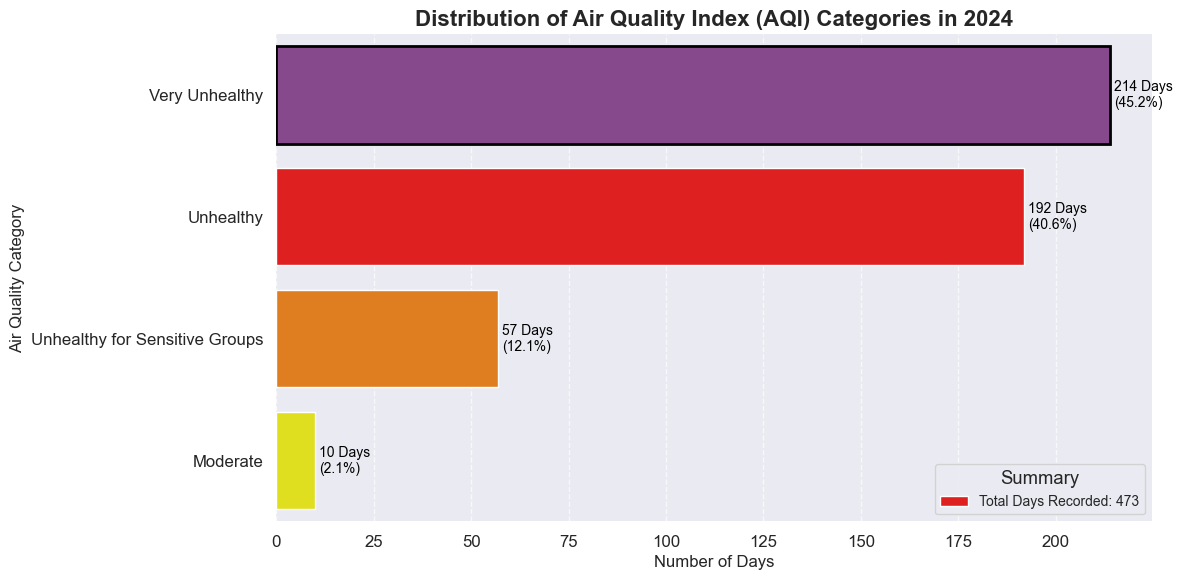

In [152]:
plot_aqi_category_distribution(year_2024, year=2024, output_path='AQI_Categories_2024_Horizontal.png')

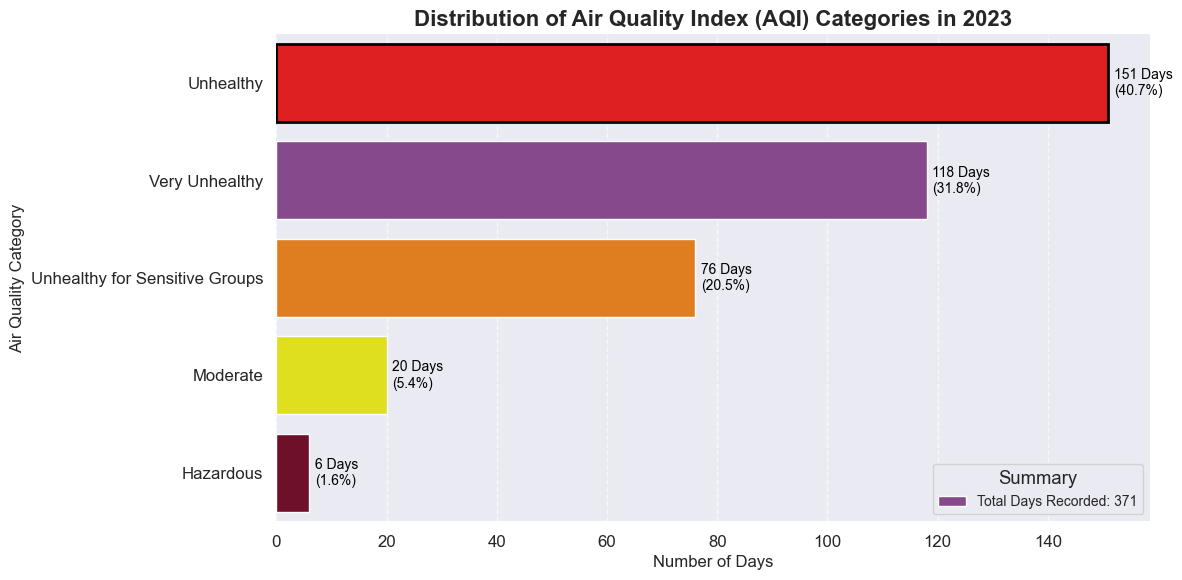

In [154]:
# plot for 2023 
plot_aqi_category_distribution(year_2021, year=2023, output_path='AQI_Categories_2023_Horizontal.png')

In [153]:
# Define a function to categorize PM2.5 values based on the breakpoints
def categorize_pm25(pm25_value):
    if pm25_value is None or np.isnan(pm25_value):
        return "Unknown"
    for i, (low, high) in enumerate(pm25_breakpoints):
        if low <= pm25_value <= high:
            return ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"][i]
    return "Unknown"

# Apply the categorization function to the 'pm25' column
year_2024['PM25_Category'] = year_2024['pm25'].apply(categorize_pm25)

# Count the occurrences of each category
pm25_category_counts = year_2024['PM25_Category'].value_counts()

print(pm25_category_counts)

PM25_Category
Very Unhealthy                    214
Unhealthy                         192
Unhealthy for Sensitive Groups     57
Moderate                           10
Name: count, dtype: int64
